#Downloads

In [ ]:
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.7 MB/s eta 0:00:00


#Imports

In [ ]:
import os
import shutil
import soundfile as sf

import torch
import torchaudio
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader, random_split, TensorDataset

from transformers import WhisperProcessor, WhisperModel, WhisperForConditionalGeneration

import librosa
import logging
import kagglehub
import numpy as np
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from dataclasses import dataclass
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


os.environ["HF_TOKEN"] = ""

#Dataset Preparation

In [ ]:
# path = kagglehub.dataset_download("kamilhanna/emotion-dataset", force_download=True)
# print("Path to dataset files:", path)

!ls "/kaggle/input/emotion-dataset/content/Emotion"

# Copy dataset to writable directory
!cp -r /kaggle/input/emotion-dataset/content/Emotion /content/

# Now remove the calm folder in working directory
!rm -rf /content/Emotion/calm

root = "/content/Emotion"

angry  calm  contempt  disgust	fear  happy  neutral  sad  surprised


In [ ]:
!rm -r "/content/Emotion"

In [ ]:
path = kagglehub.dataset_download("kamilhanna/emotion-dataset", force_download=True)
print("Path to dataset files:", path)
# !mv "{path}" "/content"
# !mv "/content/1/content/Emotion" "/content/"
# !rm -rf "/content/1"

# #Dropping this class cause low data
# !rm -rf "/content/Emotion/calm"

Using Colab cache for faster access to the 'emotion-dataset' dataset.
Path to dataset files: /kaggle/input/emotion-dataset


In [ ]:
def clean_corrupted_audio(root):
    """
    Scan all wav/m4a files under `root`.
    Delete any file that torchaudio fails to load.
    """
    removed = 0
    checked = 0

    print(f"Scanning audio under: {root}\n")

    for folder, _, files in os.walk(root):
        for f in files:
            if not f.lower().endswith((".wav", ".m4a")):
                continue

            path = os.path.join(folder, f)
            checked += 1

            try:
                # Try loading
                audio, sr = torchaudio.load(path)
            except Exception as e:
                print(f"[CORRUPTED] Removing: {path}   -->   {e}")
                try:
                    os.remove(path)
                    removed += 1
                except Exception as re:
                    print(f"[ERROR] Could not delete {path}: {re}")
                continue

    print("\n===== SUMMARY =====")
    print(f"Checked:  {checked} files")
    print(f"Removed:  {removed} corrupted files\n")
    return removed

clean_corrupted_audio("/content/Emotion")

Scanning audio under: /content/Emotion

[CORRUPTED] Removing: /content/Emotion/angry/MEAD_W_014_angry_level1_017.m4a   -->   Failed to create AudioDecoder for /content/Emotion/angry/MEAD_W_014_angry_level1_017.m4a: No valid stream found in input file. Is -1 of the desired media type?
[CORRUPTED] Removing: /content/Emotion/sad/MEAD_M_041_sad_level2_014.m4a   -->   Failed to create AudioDecoder for /content/Emotion/sad/MEAD_M_041_sad_level2_014.m4a: No valid stream found in input file. Is -1 of the desired media type?
[CORRUPTED] Removing: /content/Emotion/sad/MEAD_M_041_sad_level2_013.m4a   -->   Failed to create AudioDecoder for /content/Emotion/sad/MEAD_M_041_sad_level2_013.m4a: No valid stream found in input file. Is -1 of the desired media type?
[CORRUPTED] Removing: /content/Emotion/sad/MEAD_M_041_sad_level2_011.m4a   -->   Failed to create AudioDecoder for /content/Emotion/sad/MEAD_M_041_sad_level2_011.m4a: No valid stream found in input file. Is -1 of the desired media type?
[COR

5

In [ ]:
def audio_loader(path):

    audio, sr = torchaudio.load(path)


    # mono
    if audio.shape[0] > 1:
        audio = audio.mean(dim=0)
    else:
        audio = audio[0]


    # resample
    if sr != 16000:
        audio = torchaudio.functional.resample(audio, sr, 16000)

    return audio.contiguous()  # ensure shape = (T,)



# torchaudio.set_audio_backend("ffmpeg")
# torchaudio.set_audio_backend("soundfile")

full_dataset = datasets.DatasetFolder(
    root="/content/Emotion",
    loader=audio_loader,
    extensions=("wav", "m4a"),
    transform=None
)

train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

num_classes = len(full_dataset.classes)
print(f"number of classes is {num_classes}\nSize of train dataset {len(train_dataset)}\nSize of val dataset {len(val_dataset)}\nSize of test dataset {len(test_dataset)}")

processor = WhisperProcessor.from_pretrained("openai/whisper-large-v3")

@dataclass
class WhisperCollate:
    processor: WhisperProcessor

    def __call__(self, batch):
        audios = []
        labels = []

        for audio_tensor, label in batch:
          audio = audio_tensor.squeeze().float().cpu().numpy()
          audios.append(audio)
          labels.append(label)


        # Whisper requires mel length = 3000
        # inputs = self.processor.feature_extractor(
        #     audios,
        #     sampling_rate=16000,
        #     padding="max_length",     # THIS IS THE FIX
        #     return_attention_mask=True,
        #     return_tensors="pt"
        # )
        inputs = self.processor(
            audios,
            sampling_rate=16000,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt"
        )
        labels = torch.tensor(labels, dtype=torch.long)

        return {
            "input_features": inputs.input_features,     # (B, 80, 3000)
            "attention_mask": inputs.attention_mask,     # (B, 3000)
            "labels": labels
        }



#Dataloaders
collate_fn = WhisperCollate(processor)
BATCH_SIZE = 16
NUM_WORKERS = 0 #os.cpu_count()


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn
)


number of classes is 8
Size of train dataset 31270
Size of val dataset 3908
Size of test dataset 3910


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

#MODEL

In [ ]:
class WhisperEmotionClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # full model with encoder + decoder (needed for transcription)
        self.whisper = WhisperForConditionalGeneration.from_pretrained(
            "openai/whisper-large-v3"
        )

        # Freeze Whisper weights (optional)
        for p in self.whisper.parameters():
            p.requires_grad = False

        # Hidden size of Whisper-large-v3
        hidden_dim = self.whisper.config.d_model  # = 1280

        # Trainable classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        # Needed for decoding
        self.processor = WhisperProcessor.from_pretrained("openai/whisper-large-v3")

    def forward(self, input_features, attention_mask, generate_text=False):
        # ======= EMOTION CLASSIFICATION (from encoder) =======
        encoder_outputs = self.whisper.model.encoder(
            input_features=input_features,
            attention_mask=attention_mask,
            return_dict=True
        )

        enc = encoder_outputs.last_hidden_state  # (B, T, H)
        pooled = enc.mean(dim=1)  # mean pooling (B, H)
        emotion_logits = self.classifier(pooled)  # (B, num_classes)

        # ======= TRANSCRIPTION =======
        if generate_text:
          forced_ids = self.processor.get_decoder_prompt_ids(
              language="en",
              task="transcribe"
          )
          generated_ids = self.whisper.generate(
              input_features=input_features,
              attention_mask=attention_mask,
              forced_decoder_ids = forced_ids,
          )

          # Decode to text
          transcriptions = self.processor.batch_decode(
              generated_ids, skip_special_tokens=True
          )


          return {
              "transcription": transcriptions,  # List[str] length = batch size
              "emotion_logits": emotion_logits   # Tensor (B, num_classes)
          }
        else:
          return {"emotion_logits": emotion_logits} # Tensor (B, num_classes)


In [ ]:
# test model
model = WhisperEmotionClassifier(num_classes).cuda()

batch = next(iter(train_loader))

input_features = batch["input_features"].cuda()
attention_mask = batch["attention_mask"].cuda()

model.eval()
with torch.no_grad():
  output = model(input_features, attention_mask, generate_text=True)

print("Transcription:", output["transcription"][0])
print("Emotion logits:", output["emotion_logits"][0])

In [ ]:
# @title
class_names = full_dataset.classes
print("Classes:", class_names)

for i in range(len(output["emotion_logits"])):
  logits = output["emotion_logits"][i]
  pred_idx = logits.argmax(dim=-1).item()
  pred_label = class_names[pred_idx]

  print("Transcription:", output["transcription"][i])
  print("Emotion:", pred_label)
  print("Logits:", logits)


#Get Data ready From Encoder

Instead of doing encoder forward pass + MLP forward pass each time to train.
Convert all audio files to hidden state of encoder and create a new dataset

In [ ]:
def extract_embeddings(model, dataloader, save_path):
    """Extract encoder embeddings with improved error handling."""
    model.eval()
    all_embs = []
    all_labels = []
    skipped_batches = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting"):
            if batch is None:
                skipped_batches += 1
                logger.warning(f"Skipped batch (total: {skipped_batches})")
                continue

            try:
                feats = batch["input_features"].cuda()
                mask = batch["attention_mask"].cuda()
                labels = batch["labels"]

                enc = model.whisper.model.encoder(
                    input_features=feats,
                    attention_mask=mask,
                    return_dict=True
                ).last_hidden_state   # (B, T, 1280)
                pooled = enc.mean(dim=1).cpu()     # (B, 1280)

                all_embs.append(pooled)
                all_labels.append(labels)

            except Exception as e:
                logger.error(f"Error processing batch: {type(e).__name__} - {str(e)}")
                continue

    if len(all_embs) == 0:
        logger.error("No embeddings extracted! Check your data.")
        return

    X = torch.cat(all_embs, dim=0)     # (N, 1280)
    y = torch.cat(all_labels, dim=0)   # (N,)

    torch.save((X, y), save_path)
    print(f"Saved {len(X)} embeddings to {save_path} (Skipped {skipped_batches} batches)")

In [ ]:
# Extract embeddings
model = WhisperEmotionClassifier(num_classes).cuda()

extract_embeddings(model, train_loader, "train_emb.pt")
extract_embeddings(model, val_loader, "val_emb.pt")
extract_embeddings(model, test_loader, "test_emb.pt")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Extracting: 100%|██████████| 1955/1955 [1:12:24<00:00,  2.22s/it]


Saved 31270 embeddings to train_emb.pt (Skipped 0 batches)


Extracting: 100%|██████████| 245/245 [08:56<00:00,  2.19s/it]


Saved 3908 embeddings to val_emb.pt (Skipped 0 batches)


Extracting: 100%|██████████| 245/245 [08:56<00:00,  2.19s/it]

Saved 3910 embeddings to test_emb.pt (Skipped 0 batches)


In [ ]:
!cp "/content/test_emb.pt" "/content/drive/MyDrive/GenAI/Project"
!cp "/content/train_emb.pt" "/content/drive/MyDrive/GenAI/Project"
!cp "/content/val_emb.pt" "/content/drive/MyDrive/GenAI/Project"

In [ ]:
# Load file
X, y = torch.load("train_emb.pt")   # <-- change filename if needed

print("Embeddings shape:", X.shape)
print("Labels shape:", y.shape)

print("\n=== First 10 Embeddings ===")
for i in range(10):
    print(f"\nEmbedding {i}:")
    print(X[i])

print("\n=== First 10 Labels ===")
print(y[:10])

Embeddings shape: torch.Size([31270, 1280])
Labels shape: torch.Size([31270])

=== First 10 Embeddings ===

Embedding 0:
tensor([-0.4878,  0.3868,  0.5359,  ..., -0.2472, -0.4986, -0.0484])

Embedding 1:
tensor([-4.8183e-01,  3.8629e-01,  5.2472e-01,  ..., -2.6570e-01,
        -5.2388e-01, -2.2141e-04])

Embedding 2:
tensor([-0.4665,  0.3472,  0.5455,  ..., -0.3605, -0.4679, -0.0665])

Embedding 3:
tensor([-0.4881,  0.3898,  0.5548,  ..., -0.2838, -0.4894, -0.0739])

Embedding 4:
tensor([-0.4878,  0.4399,  0.5436,  ..., -0.2901, -0.5182, -0.0486])

Embedding 5:
tensor([-0.4902,  0.3938,  0.5756,  ..., -0.2919, -0.5363, -0.0237])

Embedding 6:
tensor([-0.4869,  0.3843,  0.5402,  ..., -0.3277, -0.5082, -0.0216])

Embedding 7:
tensor([-0.4893,  0.3203,  0.5379,  ..., -0.3129, -0.4374, -0.0303])

Embedding 8:
tensor([-0.4721,  0.3728,  0.5689,  ..., -0.3299, -0.5269, -0.0114])

Embedding 9:
tensor([-0.4954,  0.3687,  0.5287,  ..., -0.2763, -0.4715, -0.0153])

=== First 10 Labels ===
tensor

#Train MLP on Encoder Hidden State

In [ ]:
class EmbDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X.float()
        self.y = y.long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
path = "/content/drive/MyDrive/GenAI/Project"
X_train, y_train = torch.load(f"{path}/train_emb.pt")
X_val, y_val = torch.load(f"{path}/val_emb.pt")
X_test, y_test = torch.load(f"{path}/test_emb.pt")
train_ds = EmbDataset(X_train, y_train)
val_ds   = EmbDataset(X_val, y_val)
test_ds  = EmbDataset(X_test, y_test)


BATCH_SIZE = 256
NUM_WORKERS = 4
train_loader2 = DataLoader(train_ds,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           num_workers=NUM_WORKERS,
                           pin_memory=True)
val_loader2 = DataLoader(val_ds,
                           batch_size=BATCH_SIZE,
                           shuffle=False,
                           num_workers=NUM_WORKERS,
                           pin_memory=True)
test_loader2 = DataLoader(test_ds,
                           batch_size=BATCH_SIZE,
                           shuffle=False,
                           num_workers=NUM_WORKERS,
                           pin_memory=True)
num_classes = len(y_train.unique())
print(num_classes)

8


In [ ]:
MODEL_HIDDEN_DIMENSION = 1280
class EmotionClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        hidden_1 = MODEL_HIDDEN_DIMENSION // 2
        hidden_2 = MODEL_HIDDEN_DIMENSION // 4
        hidden_3 = MODEL_HIDDEN_DIMENSION // 8

        # self.net = nn.Sequential(
        #     nn.Linear(MODEL_HIDDEN_DIMENSION, MODEL_HIDDEN_DIMENSION // 2),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(MODEL_HIDDEN_DIMENSION // 2, MODEL_HIDDEN_DIMENSION // 4),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(MODEL_HIDDEN_DIMENSION // 4, num_classes)
        # )

        # self.net = nn.Sequential(
        #     nn.Linear(MODEL_HIDDEN_DIMENSION, hidden_1),
        #     nn.GELU(),
        #     nn.Dropout(0.15),
        #     nn.BatchNorm1d(hidden_1),

        #     nn.Linear(hidden_1, hidden_1),
        #     nn.GELU(),
        #     nn.Dropout(0.15),
        #     nn.BatchNorm1d(hidden_1),

        #     nn.Linear(hidden_1, hidden_1),
        #     nn.GELU(),
        #     nn.Dropout(0.15),
        #     nn.BatchNorm1d(hidden_1),

        #     nn.Linear(hidden_1, hidden_1),
        #     nn.GELU(),
        #     nn.Dropout(0.15),
        #     nn.BatchNorm1d(hidden_1),

        #     nn.Linear(hidden_1, hidden_2),
        #     nn.GELU(),
        #     nn.Dropout(0.15),
        #     nn.BatchNorm1d(hidden_2),

        #     nn.Linear(hidden_2, hidden_2),
        #     nn.GELU(),
        #     nn.Dropout(0.15),
        #     nn.BatchNorm1d(hidden_2),

        #     nn.Linear(hidden_2, hidden_2),
        #     nn.GELU(),
        #     nn.Dropout(0.15),
        #     nn.BatchNorm1d(hidden_2),

        #     nn.Linear(hidden_2, hidden_3),
        #     nn.GELU(),
        #     nn.Dropout(0.15),
        #     nn.BatchNorm1d(hidden_3),

        #     nn.Linear(hidden_3, num_classes)
        # )

        #0.77
        # hidden_1 = 1024
        # hidden_2 = 512
        # hidden_3 = 256
        # hidden_4 = 128
        # hidden_5 = 64
        # self.net = nn.Sequential(
        #     nn.Linear(MODEL_HIDDEN_DIMENSION, hidden_1),
        #     nn.GELU(),
        #     nn.Dropout(0.15),
        #     nn.BatchNorm1d(hidden_1),

        #     nn.Linear(hidden_1, hidden_2),
        #     nn.GELU(),
        #     nn.Dropout(0.15),
        #     nn.BatchNorm1d(hidden_2),

        #     nn.Linear(hidden_2, hidden_3),
        #     nn.GELU(),
        #     nn.Dropout(0.15),
        #     nn.BatchNorm1d(hidden_3),

        #     nn.Linear(hidden_3, hidden_3),
        #     nn.GELU(),
        #     nn.Dropout(0.15),
        #     nn.BatchNorm1d(hidden_3),

        #     nn.Linear(hidden_3, hidden_4),
        #     nn.GELU(),
        #     nn.Dropout(0.15),
        #     nn.BatchNorm1d(hidden_4),

        #     nn.Linear(hidden_4, hidden_5),
        #     nn.GELU(),
        #     nn.Dropout(0.15),
        #     nn.BatchNorm1d(hidden_5),

        #     nn.Linear(hidden_5, num_classes)
        # )

        #83 + 84% test
        hidden_1 = 1024
        hidden_2 = 512
        hidden_3 = 256
        hidden_4 = 128
        hidden_5 = 64
        self.net = nn.Sequential(
            nn.Linear(MODEL_HIDDEN_DIMENSION, MODEL_HIDDEN_DIMENSION * 2),
            nn.GELU(),
            nn.Dropout(0.15),
            nn.BatchNorm1d(MODEL_HIDDEN_DIMENSION * 2),

            nn.Linear(MODEL_HIDDEN_DIMENSION * 2, hidden_1),
            nn.GELU(),
            nn.Dropout(0.15),
            nn.BatchNorm1d(hidden_1),

            nn.Linear(hidden_1, hidden_2),
            nn.GELU(),
            nn.Dropout(0.15),
            nn.BatchNorm1d(hidden_2),

            nn.Linear(hidden_2, hidden_3),
            nn.GELU(),
            nn.Dropout(0.15),
            nn.BatchNorm1d(hidden_3),

            nn.Linear(hidden_3, hidden_3),
            nn.GELU(),
            nn.Dropout(0.15),
            nn.BatchNorm1d(hidden_3),

            nn.Linear(hidden_3, hidden_4),
            nn.GELU(),
            nn.Dropout(0.15),
            nn.BatchNorm1d(hidden_4),

            nn.Linear(hidden_4, hidden_5),
            nn.GELU(),
            nn.Dropout(0.15),
            nn.BatchNorm1d(hidden_5),

            nn.Linear(hidden_5, num_classes)
        )

        # self.net = nn.Sequential(
        #     nn.Linear(1280, 1024),
        #     nn.ReLU(),
        #     nn.Dropout(0.2),

        #     nn.Linear(1024, 512),
        #     nn.ReLU(),
        #     nn.Dropout(0.2),

        #     nn.Linear(512, 256),
        #     nn.ReLU(),

        #     nn.Linear(256, num_classes)
        # )

    def forward(self, x):
        return self.net(x)


In [ ]:
def accuracy_from_logits(logits, labels):
    preds = logits.argmax(dim=-1)
    return (preds == labels).float().mean().item()

def train_model(model, train_loader, val_loader, num_epochs=20):

    model = model.cuda()
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode="max", factor=0.5, patience=3, min_lr=1e-6
    # )
    # T_max = 300
    # eta_min = 1e-6
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    #     optimizer,
    #     T_max=T_max,
    #     eta_min=eta_min
    # )
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=3e-4,
        steps_per_epoch=len(train_loader),
        epochs=num_epochs,
        pct_start=0.3,
    )

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        if (epoch + 1) % 10 == 0:
          print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        pbar = tqdm(train_loader, desc="Training", leave=False)
        for batch in pbar:
            X, y = batch
            X, y = X.cuda(), y.cuda()

            optimizer.zero_grad()

            out = model(X)

            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            acc = accuracy_from_logits(out, y)

            train_loss += loss.item()
            train_acc += acc

            pbar.set_postfix(loss=loss.item(), acc=acc)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            pbar = tqdm(val_loader, desc="Validation", leave=False)
            for batch in pbar:
                X, y = batch
                X, y = X.cuda(), y.cuda()

                out = model(X)

                loss = criterion(out, y)
                acc = accuracy_from_logits(out, y)

                val_loss += loss.item()
                val_acc += acc

                pbar.set_postfix(loss=loss.item(), acc=acc)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)


        # scheduler.step(val_acc)
        scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")
            # print(f"✔️ New best val accuracy: {val_acc:.4f} — model saved.")

        if (epoch +  1) % 10 == 0:
          print(
              f"Epoch {epoch+1} Summary:\n"
              f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}\n"
              f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}\n"
              f"  LR:         {optimizer.param_groups[0]['lr']:.6f}\n"
              f"  Best Val Acc So Far: {best_val_acc:.4f}"
          )

    print("\nTraining finished!")
    return best_val_acc
model = EmotionClassifier(num_classes)
train_model(model, train_loader2, val_loader2, num_epochs=300)


===== Epoch 10/300 =====


Epoch 10 Summary:
  Train Loss: 1.6974 | Train Acc: 0.3985
  Val Loss:   1.5472 | Val Acc:   0.4968
  LR:         0.000012
  Best Val Acc So Far: 0.4968



===== Epoch 20/300 =====


Epoch 20 Summary:
  Train Loss: 1.2371 | Train Acc: 0.6256
  Val Loss:   1.1084 | Val Acc:   0.6678
  LR:         0.000012
  Best Val Acc So Far: 0.6678



===== Epoch 30/300 =====


Epoch 30 Summary:
  Train Loss: 1.0190 | Train Acc: 0.7052
  Val Loss:   0.9381 | Val Acc:   0.7261
  LR:         0.000012
  Best Val Acc So Far: 0.7261



===== Epoch 40/300 =====


Epoch 40 Summary:
  Train Loss: 0.9057 | Train Acc: 0.7489
  Val Loss:   0.8751 | Val Acc:   0.7470
  LR:         0.000012
  Best Val Acc So Far: 0.7477



===== Epoch 50/300 =====


Epoch 50 Summary:
  Train Loss: 0.8328 | Train Acc: 0.7744
  Val Loss:   0.8582 | Val Acc:   0.7503
  LR:         0.000012
  Best Val Acc So Far: 0.7679



===== Epoch 60/300 =====


Epoch 60 Summary:
  Train Loss: 0.7757 | Train Acc: 0.7976
  Val Loss:   0.8159 | Val Acc:   0.7721
  LR:         0.000012
  Best Val Acc So Far: 0.7722



===== Epoch 70/300 =====


Epoch 70 Summary:
  Train Loss: 0.7255 | Train Acc: 0.8197
  Val Loss:   0.8049 | Val Acc:   0.7759
  LR:         0.000012
  Best Val Acc So Far: 0.7834



===== Epoch 80/300 =====


Epoch 80 Summary:
  Train Loss: 0.6835 | Train Acc: 0.8359
  Val Loss:   0.8259 | Val Acc:   0.7692
  LR:         0.000012
  Best Val Acc So Far: 0.7949



===== Epoch 90/300 =====


Epoch 90 Summary:
  Train Loss: 0.6463 | Train Acc: 0.8499
  Val Loss:   0.8078 | Val Acc:   0.7784
  LR:         0.000012
  Best Val Acc So Far: 0.7964



===== Epoch 100/300 =====


Epoch 100 Summary:
  Train Loss: 0.6146 | Train Acc: 0.8630
  Val Loss:   0.7493 | Val Acc:   0.7975
  LR:         0.000012
  Best Val Acc So Far: 0.8009



===== Epoch 110/300 =====


Epoch 110 Summary:
  Train Loss: 0.5788 | Train Acc: 0.8774
  Val Loss:   0.7991 | Val Acc:   0.7849
  LR:         0.000012
  Best Val Acc So Far: 0.8039



===== Epoch 120/300 =====


Epoch 120 Summary:
  Train Loss: 0.5553 | Train Acc: 0.8890
  Val Loss:   0.7350 | Val Acc:   0.8116
  LR:         0.000012
  Best Val Acc So Far: 0.8116



===== Epoch 130/300 =====


Epoch 130 Summary:
  Train Loss: 0.5240 | Train Acc: 0.9006
  Val Loss:   0.7504 | Val Acc:   0.8068
  LR:         0.000012
  Best Val Acc So Far: 0.8174



===== Epoch 140/300 =====


Epoch 140 Summary:
  Train Loss: 0.5058 | Train Acc: 0.9087
  Val Loss:   0.7494 | Val Acc:   0.8115
  LR:         0.000012
  Best Val Acc So Far: 0.8174



===== Epoch 150/300 =====


Epoch 150 Summary:
  Train Loss: 0.4913 | Train Acc: 0.9162
  Val Loss:   0.7614 | Val Acc:   0.8112
  LR:         0.000012
  Best Val Acc So Far: 0.8209



===== Epoch 160/300 =====


Epoch 160 Summary:
  Train Loss: 0.4638 | Train Acc: 0.9257
  Val Loss:   0.7421 | Val Acc:   0.8188
  LR:         0.000012
  Best Val Acc So Far: 0.8234



===== Epoch 170/300 =====


Epoch 170 Summary:
  Train Loss: 0.4476 | Train Acc: 0.9334
  Val Loss:   0.7425 | Val Acc:   0.8167
  LR:         0.000012
  Best Val Acc So Far: 0.8234



===== Epoch 180/300 =====


Epoch 180 Summary:
  Train Loss: 0.4422 | Train Acc: 0.9343
  Val Loss:   0.7252 | Val Acc:   0.8245
  LR:         0.000012
  Best Val Acc So Far: 0.8248



===== Epoch 190/300 =====


Epoch 190 Summary:
  Train Loss: 0.4210 | Train Acc: 0.9452
  Val Loss:   0.7434 | Val Acc:   0.8181
  LR:         0.000012
  Best Val Acc So Far: 0.8248



===== Epoch 200/300 =====


Epoch 200 Summary:
  Train Loss: 0.4167 | Train Acc: 0.9463
  Val Loss:   0.7363 | Val Acc:   0.8193
  LR:         0.000012
  Best Val Acc So Far: 0.8266



===== Epoch 210/300 =====


Epoch 210 Summary:
  Train Loss: 0.4009 | Train Acc: 0.9527
  Val Loss:   0.7418 | Val Acc:   0.8218
  LR:         0.000012
  Best Val Acc So Far: 0.8279



===== Epoch 220/300 =====


Epoch 220 Summary:
  Train Loss: 0.3926 | Train Acc: 0.9557
  Val Loss:   0.7462 | Val Acc:   0.8247
  LR:         0.000012
  Best Val Acc So Far: 0.8312



===== Epoch 230/300 =====


Epoch 230 Summary:
  Train Loss: 0.3823 | Train Acc: 0.9602
  Val Loss:   0.7611 | Val Acc:   0.8178
  LR:         0.000012
  Best Val Acc So Far: 0.8336



===== Epoch 240/300 =====


Epoch 240 Summary:
  Train Loss: 0.3732 | Train Acc: 0.9635
  Val Loss:   0.7405 | Val Acc:   0.8260
  LR:         0.000012
  Best Val Acc So Far: 0.8336



===== Epoch 250/300 =====


Epoch 250 Summary:
  Train Loss: 0.3661 | Train Acc: 0.9664
  Val Loss:   0.7618 | Val Acc:   0.8213
  LR:         0.000012
  Best Val Acc So Far: 0.8336



===== Epoch 260/300 =====


Epoch 260 Summary:
  Train Loss: 0.3703 | Train Acc: 0.9643
  Val Loss:   0.7452 | Val Acc:   0.8272
  LR:         0.000012
  Best Val Acc So Far: 0.8361



===== Epoch 270/300 =====


Epoch 270 Summary:
  Train Loss: 0.3506 | Train Acc: 0.9732
  Val Loss:   0.7677 | Val Acc:   0.8195
  LR:         0.000012
  Best Val Acc So Far: 0.8361



===== Epoch 280/300 =====


Epoch 280 Summary:
  Train Loss: 0.3526 | Train Acc: 0.9716
  Val Loss:   0.7371 | Val Acc:   0.8333
  LR:         0.000012
  Best Val Acc So Far: 0.8361



===== Epoch 290/300 =====


Epoch 290 Summary:
  Train Loss: 0.3395 | Train Acc: 0.9774
  Val Loss:   0.7416 | Val Acc:   0.8320
  LR:         0.000012
  Best Val Acc So Far: 0.8361



===== Epoch 300/300 =====


Epoch 300 Summary:
  Train Loss: 0.3362 | Train Acc: 0.9779
  Val Loss:   0.7389 | Val Acc:   0.8294
  LR:         0.000013
  Best Val Acc So Far: 0.8361

Training finished!


0.8360667526721954

Test Accuracy: 0.838618925831202


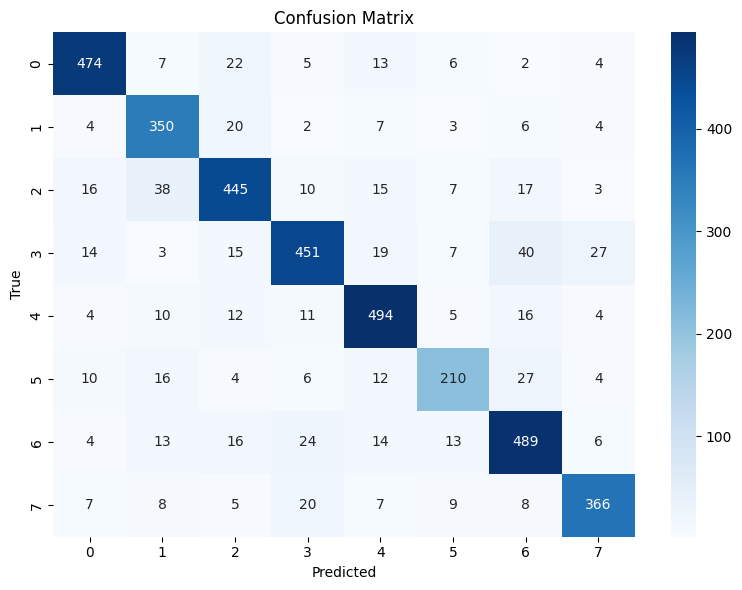

In [ ]:
def evaluate_test(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in test_loader:
            X = X.cuda()
            y = y.cuda()

            logits = model(X)
            preds = logits.argmax(dim=-1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    test_acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    return test_acc, cm


#RUN IT
model.load_state_dict(torch.load("best_model.pt"))
model = model.cuda()
model.eval()
test_acc, cm = evaluate_test(model, test_loader2)

print("Test Accuracy:", test_acc)

# ---- CONFUSION MATRIX PLOT ----
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


#Training of encoder + MLP did not work well

In [ ]:
def accuracy_from_logits(logits, labels):
    preds = logits.argmax(dim=-1)
    return (preds == labels).float().mean().item()

def train_model(model, train_loader, val_loader, num_epochs=20):

    model = model.cuda()
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=3, min_lr=1e-6
    )

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        pbar = tqdm(train_loader, desc="Training", leave=False)
        for batch in pbar:
            input_features = batch["input_features"].cuda()
            attention_mask = batch["attention_mask"].cuda()
            labels = batch["labels"].cuda()

            optimizer.zero_grad()

            out = model(input_features, attention_mask, generate_text=False)
            logits = out["emotion_logits"]

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            acc = accuracy_from_logits(logits, labels)

            train_loss += loss.item()
            train_acc += acc

            pbar.set_postfix(loss=loss.item(), acc=acc)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            pbar = tqdm(val_loader, desc="Validation", leave=False)
            for batch in pbar:
                input_features = batch["input_features"].cuda()
                attention_mask = batch["attention_mask"].cuda()
                labels = batch["labels"].cuda()

                out = model(input_features, attention_mask, generate_text=False)
                logits = out["emotion_logits"]

                loss = criterion(logits, labels)
                acc = accuracy_from_logits(logits, labels)

                val_loss += loss.item()
                val_acc += acc

                pbar.set_postfix(loss=loss.item(), acc=acc)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)


        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")
            print(f"✔️ New best val accuracy: {val_acc:.4f} — model saved.")

        print(
            f"Epoch {epoch+1} Summary:\n"
            f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}\n"
            f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}\n"
            f"  Best Val Acc So Far: {best_val_acc:.4f}"
        )

    print("\nTraining finished!")
    return best_val_acc
model = WhisperEmotionClassifier(num_classes).cuda()
train_model(model, train_loader, val_loader, num_epochs=20)

#EVALUATION of encoder + MLP

In [ ]:
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_features = batch["input_features"].cuda()
            labels = batch["labels"].cuda()

            logits, _ = model(input_features)
            preds = logits.argmax(dim=-1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    return all_labels, all_preds

# Load best model
model = WhisperEmotionClassifier(num_classes).cuda()
model.load_state_dict(torch.load("best_model.pt"))

# Collect predictions
true_labels, pred_labels = get_predictions(model, test_loader)

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
class_names = full_dataset.classes

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Emotion Classification Confusion Matrix")
plt.show()